# Skin Cancer Recognition 

In [1]:
import numpy as np
import pandas as pd
import os 
import torch.utils.data as data
import keras
import random 
import itertools
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras.preprocessing.image import img_to_array,array_to_img, load_img
from keras.utils import to_categorical
from keras import backend as K
from keras import metrics
from keras.optimizers import Adam, RMSprop,SGD
from keras.preprocessing import image
# from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from numpy import array
from PIL import Image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('', 'dataset')

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# Graphics in SVG| format are more sharp and legible
%config InlineBackend.figure_format = 'svg'


Using TensorFlow backend.


# Read additional data

In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

### Cutting our dataset for some classes

In [3]:
def getRandomNV(x):
    rnd = random.randint(0, 100)
    if x == 'nv' and rnd < 50:
        return '1'
    else:
        return '0'

skin_data['usable'] = skin_data['dx'].apply(lambda x: getRandomNV(x))
skin_data['usable'].value_counts()

# current_skin_data = skin_data[(skin_data['dx'] == 'bkl') |
#                           ((skin_data['dx'] == 'nv') & (skin_data['usable'] == '1' )) | 
#                           (skin_data['dx'] == 'mel') | 
#                           (skin_data['dx'] == 'bcc') ]
current_skin_data = skin_data
current_skin_data.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [4]:
current_skin_data['cell_type_idx'].head()

0    2
1    2
2    2
3    2
4    2
Name: cell_type_idx, dtype: int8

### Loading images using opencv2 library, and choose with atm (Adaptive Mean Thresholding ) channel or without atm. 

In [5]:
frth_channel_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
IMAGE_DIMS = (100, 75, 3)
# default loading
def load_img(imagePath):
    image = cv2.imread(imagePath, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    return image

# return image with higher increase brightness
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = cv2.resize(hsv, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img_to_array(img)
    return img

# return thresholding featrue transformation
def thresholding_feature(imagePath):
    img_grey = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    img_grey = cv2.resize(img_grey, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    img_grey = cv2.adaptiveThreshold(img_grey, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    blur = cv2.GaussianBlur(img_grey, (3, 3), 0)
    ret3, img_binary = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_binary = img_to_array(img_binary)
    return img_binary 

def load_atm_img(imagePath):
    img = cv2.imread(imagePath,0)
    img = cv2.resize(img, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    atm_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
    # TODO make it gray     
    atm_img = img_to_array(atm_img)
    return atm_img

def load_img_with_cv2(imagePath, frth_channel = 'without'):
    channel = False
    image = load_img(imagePath)
    sub_channel = 'no_channel'
    if frth_channel == 'atm':
        sub_channel = load_atm_img(imagePath)
        channel = True
    elif frth_channel == 'gray': 
        sub_channel = increase_brightness(image, 150)
        channel = True
    elif frth_channel == 'threshold':
        sub_channel = thresholding_feature(imagePath)
        channel = True
    image = img_to_array(image)
    if channel == True:
        multiImage = np.concatenate((image, sub_channel), axis=2) 
        return multiImage
    else: 
        return image
    
def load_gray(imagePath):
    image = load_img(imagePath)
    return increase_brightness(image, 150)

### load baseline image data 

In [6]:
data = []
for img_path in current_skin_data['path']:
    data.append(load_img_with_cv2(img_path, 'threshold'))

In [7]:
labels = np.array(current_skin_data['cell_type_idx'])

In [8]:
labels = np.array(labels)
data = np.array(data)

In [9]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(
        data, labels, test_size=0.2, random_state=42)

In [10]:
x_train_mean = np.mean(x_train_)
x_train_std = np.std(x_train_)
x_train = (x_train_ - x_train_mean)/x_train_std

In [11]:
x_test_mean = np.mean(x_test_)
x_test_std = np.std(x_test_)
x_test = (x_test_ - x_test_mean)/x_test_std

In [12]:
y_train = to_categorical(y_train_, num_classes = 7)
y_test = to_categorical(y_test_, num_classes = 7)

In [13]:
x_train, x_validate, y_train, y_validate = train_test_split(
        x_train, y_train, 
        test_size = 0.1, random_state = 2)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(7210, 100, 75, 4)
(7210, 7)
(2003, 100, 75, 4)
(2003, 7)
(802, 100, 75, 4)
(802, 7)


# Data Augmentation

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Define metrics and optimizer for our model

In [16]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [17]:
def task_optimizer(optimizer):
    if (optimizer == "SGD"):
        return SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    elif (optimizer == "RMSprop"):
        return RMSprop()
    elif (optimizer == "Adam"):
        return Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    else: 
        return Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

OPT = task_optimizer('Adam')
OPT

# Neural Network Topology C

In [18]:
from keras.metrics import categorical_accuracy

In [125]:
from keras import backend as K
K.set_image_dim_ordering('tf')

In [19]:
def get_model(output_neurons = 7): 
    #  input shape using shape off test samples
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), input_shape=(100,75,4)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(128))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(output_neurons))
    model.add(layers.Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer = OPT,
                  metrics=['accuracy'])
    model.summary()
    return model

# Обучим нейронную сеть 



In [20]:
MD = get_model()

# Fit the model
epochs = 30 
batch_size = 10
history = MD.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 73, 32)        1184      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 73, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 34, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 47, 34, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 15, 64)        18496     
__________

# Build graphics of CNN education 


In [21]:
loss, accuracy = MD.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = MD.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f  "  % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f ;" % (accuracy, loss))
# model.save_weights("weights.h5")
# print("Saved model to disk")

802/802 [==============================] - 0s 312us/step
Validation: accuracy = 0.725686  ;  loss = 0.788697  
Test: accuracy = 0.747379  ;  loss = 0.710183 ;


# Create a loss and accuracy plot 

In [23]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [24]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

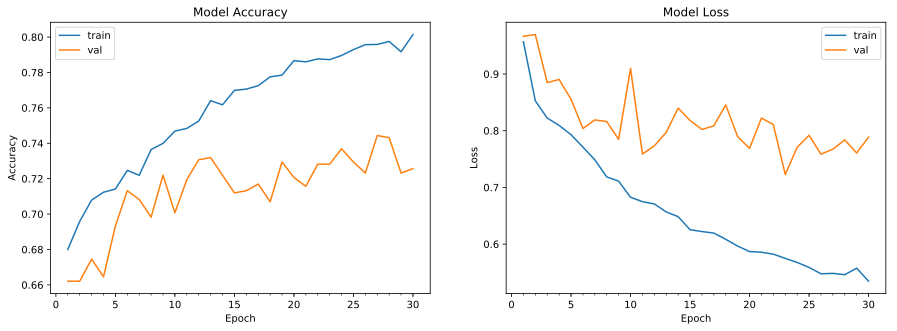

In [25]:
plot_model_history(history)

# Create a confusion matrix


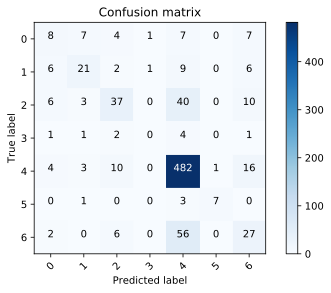

In [22]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = MD.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [26]:
current_skin_data['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

which category has much incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

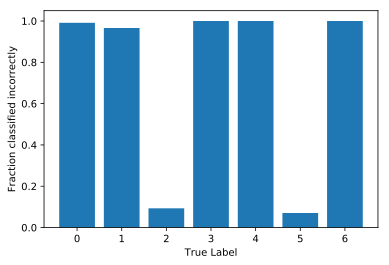

In [17]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

# Выгрузим промежуточные изображения из слоёв нейронной сети 

Функция для отрисовки изображений

In [40]:
def print_map_features(activation):
    images_per_row = 8
    n_filters = activation.shape[-1]
    size = activation.shape[1]
    size2 = activation.shape[2]
    n_cols = n_filters // images_per_row
    display_grid = np.zeros((n_cols * size, images_per_row * size2))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size2 : (row + 1) * size2] = channel_image
        
    scale = 2.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [43]:
img_for_feature_draw = x_test[120]

# Первый слой 

In [48]:
first_activation_model = models.Model(inputs=model.input, outputs=model.layers[0].output)
first_layers_activation = first_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
first_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


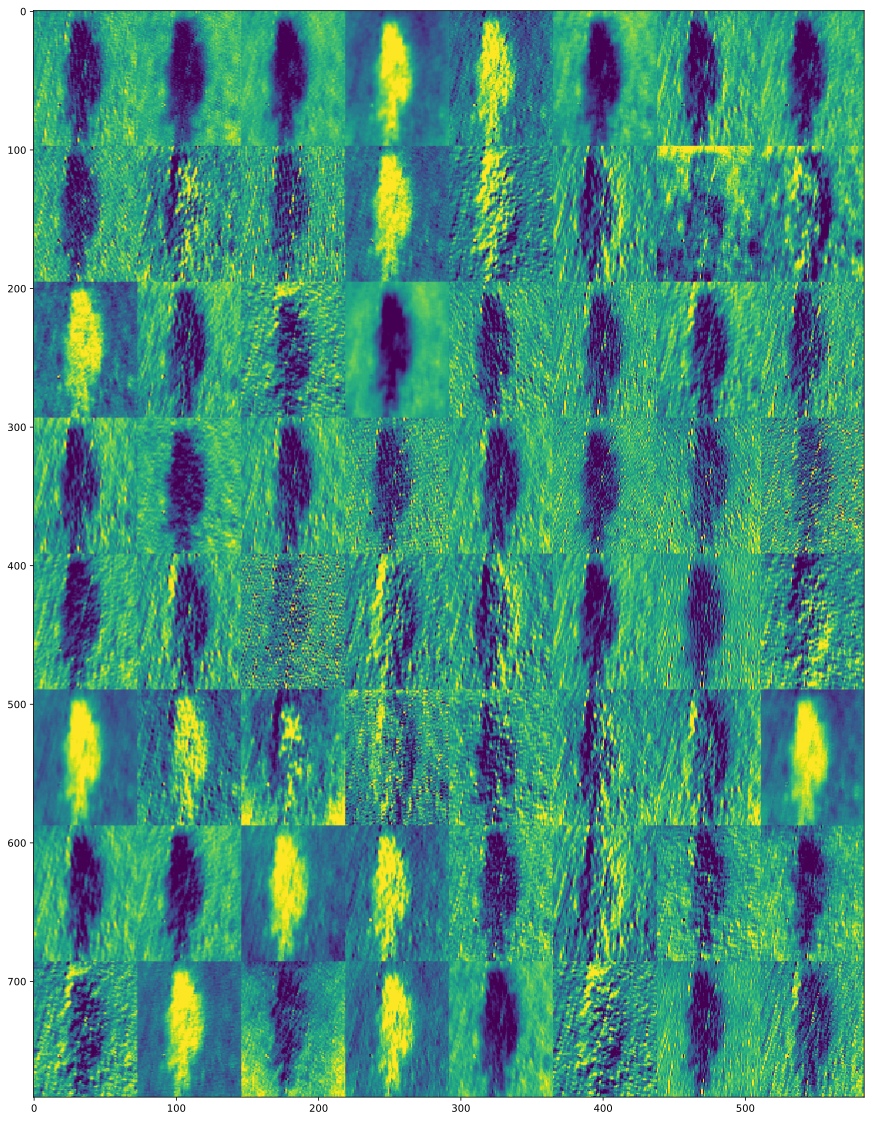

In [49]:
print_map_features(first_layers_activation)

# Второй слой 

In [50]:
second_activation_model = models.Model(inputs=model.input, outputs=model.layers[3].output)
second_layers_activation = second_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
second_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 98, 73, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 34, 64)        36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


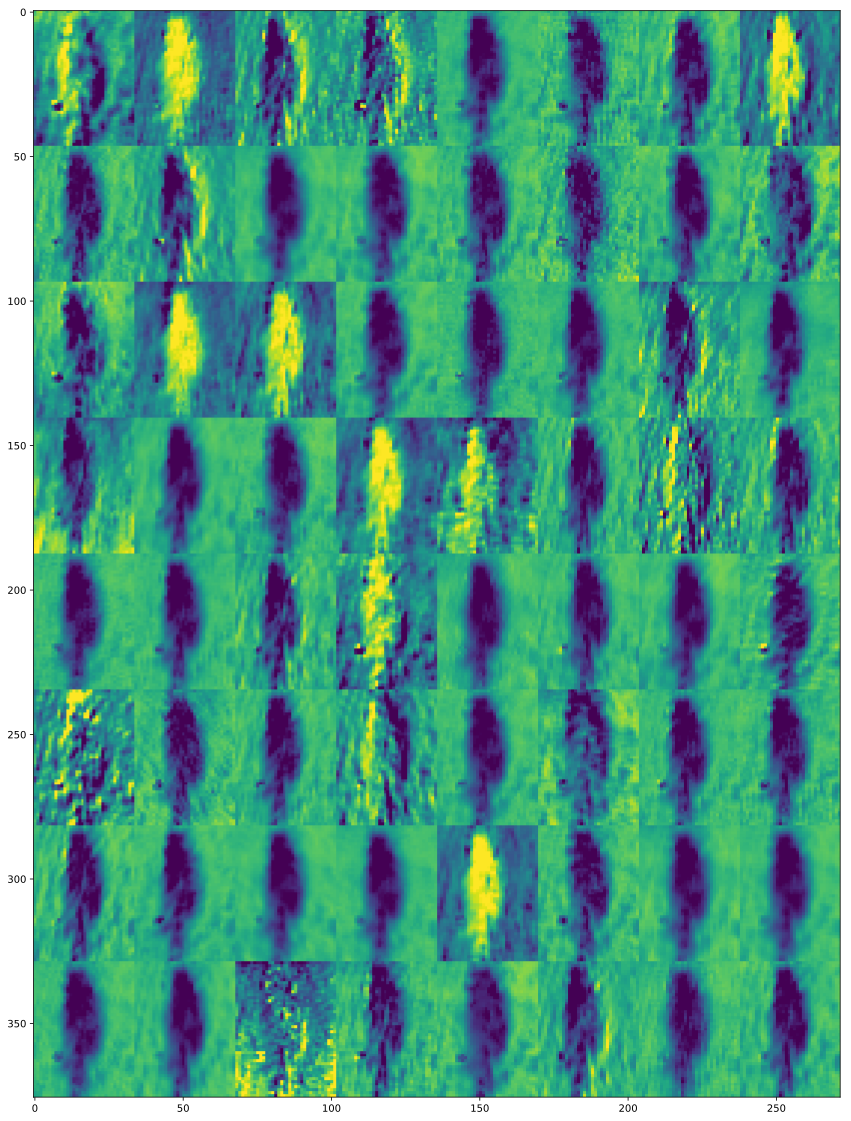

In [51]:
print_map_features(second_layers_activation)

# Третий слой

In [52]:
third_activation_model = models.Model(inputs=model.input, outputs=model.layers[6].output)
third_layers_activation = third_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
third_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 98, 73, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 34, 64)        36928     
_________________________________________________________________
activation_9 (Activation)    (None, 47, 34, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 17, 64)        0         
__________

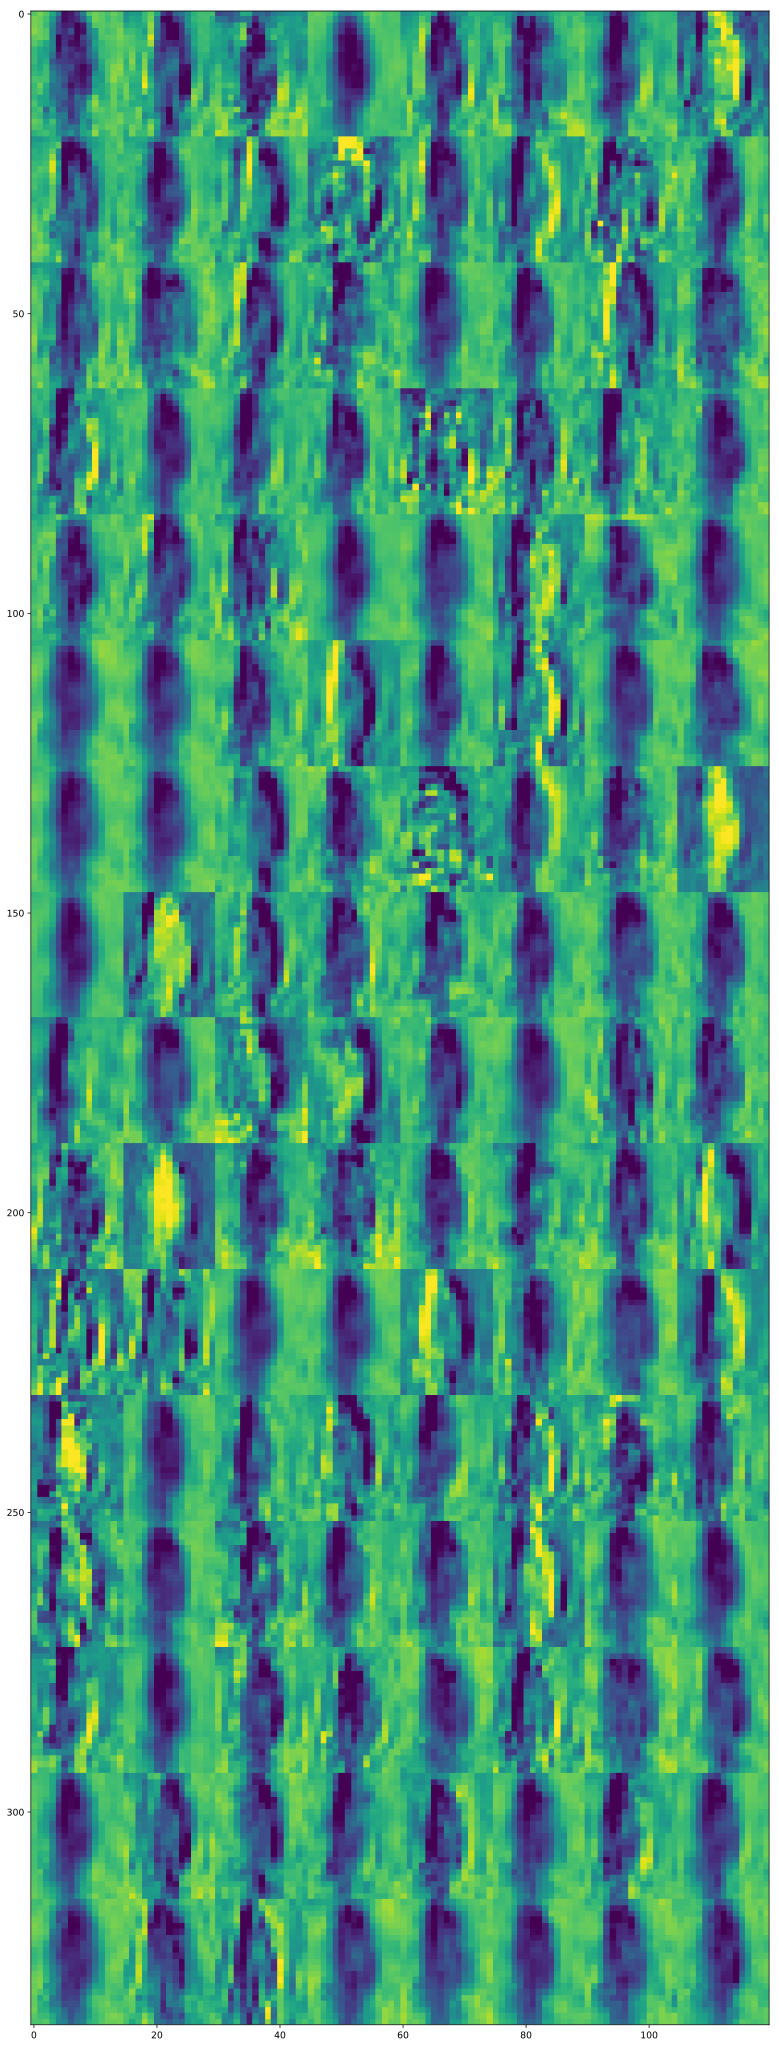

In [53]:
print_map_features(third_layers_activation)

# Четвертый слой 

In [54]:
Frth_activation_model = models.Model(inputs=model.input, outputs=model.layers[9].output)
Frth_layers_activation = Frth_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
Frth_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 98, 73, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 34, 64)        36928     
_________________________________________________________________
activation_9 (Activation)    (None, 47, 34, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 17, 64)        0         
__________

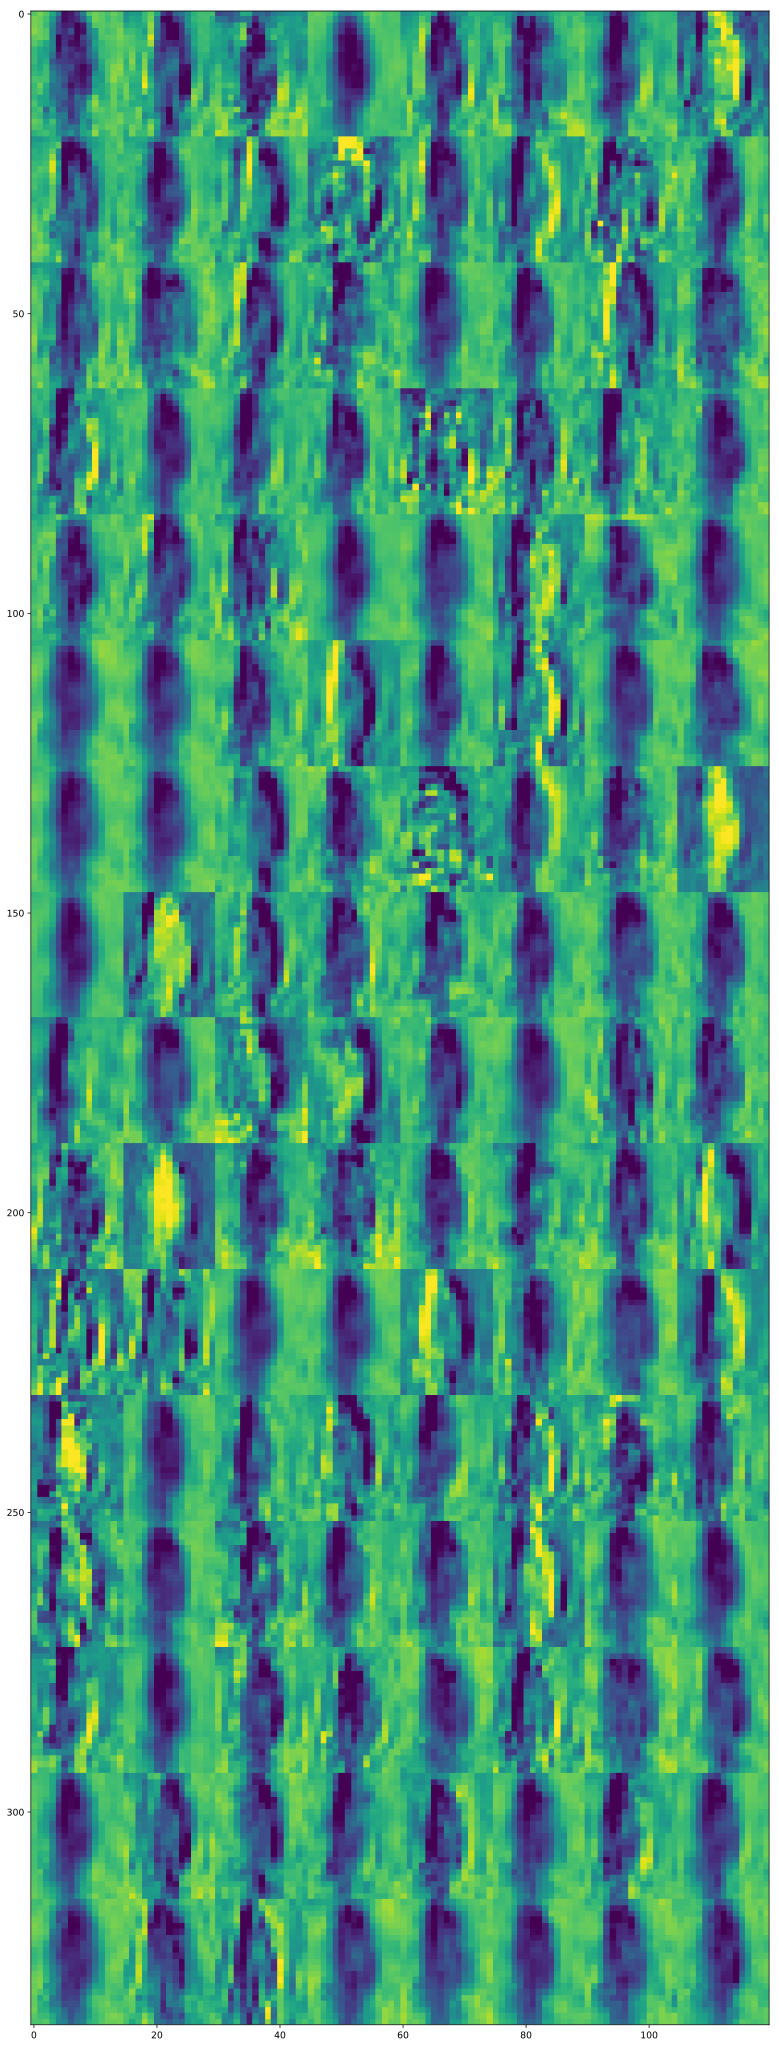

In [55]:
print_map_features(third_layers_activation)

# визуализируем веса слоёв нейронной сети 